> # HIV PREDICTION & ANALYSIS


**GROUP MEMBERS**

- Abdullah Azher Chaudhary 2022-CS-204
- Muhammad Abubakar 2022-CS-188

In [ ]:
pip install optuna catboost

In [ ]:
import kagglehub
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna, warnings, random
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

%matplotlib inline
plt.style.use('dark_background')
warnings.simplefilter('ignore', category=FutureWarning)

In [ ]:
path = kagglehub.dataset_download('aadarshvelu/aids-virus-infection-prediction')
print('Data source import complete.')
os.listdir(path)

Data source import complete.


['AIDS_Classification_5000.csv',
 'AIDS_Classification.csv',
 'AIDS_Classification_50000.csv',
 'AIDS_Classification_15000.csv']

### Data **Loading**

**Context :**

Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS.

**Attribute Information :**
* time: time to failure or censoring
* trt: treatment indicator (0 = ZDV only; 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only)
* age: age (yrs) at baseline
* wtkg: weight (kg) at baseline
* hemo: hemophilia (0=no, 1=yes)
* homo: homosexual activity (0=no, 1=yes)
* drugs: history of IV drug use (0=no, 1=yes)
* karnof: Karnofsky score (on a scale of 0-100)
* oprior: Non-ZDV antiretroviral therapy pre-175 (0=no, 1=yes)
* z30: ZDV in the 30 days prior to 175 (0=no, 1=yes)
* preanti: days pre-175 anti-retroviral therapy
* race: race (0=White, 1=non-white)
* gender: gender (0=F, 1=M)
* str2: antiretroviral history (0=naive, 1=experienced)
* strat: antiretroviral history stratification (1='Antiretroviral Naive',2='> 1 but <= 52 weeks of prior antiretroviral therapy',3='> 52 weeks)
* symptom: symptomatic indicator (0=asymp, 1=symp)
* treat: treatment indicator (0=ZDV only, 1=others)
* offtrt: indicator of off-trt before 96+/-5 weeks (0=no,1=yes)
* cd40: CD4 at baseline
* cd420: CD4 at 20+/-5 weeks
* cd80: CD8 at baseline
* cd820: CD8 at 20+/-5 weeks
* infected: is infected with AIDS (0=No, 1=Yes)

**Additional Variable Information :**
* Personal information (age, weight, race, gender, sexual activity)
* Medical history (hemophilia, history of IV drugs)
* Treatment history (ZDV/non-ZDV treatment history)
* Lab results (CD4/CD8 counts)

In [ ]:
df = pd.read_csv(path + '//AIDS_Classification.csv')
df.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


### Data *Insights*

In [ ]:
pd.DataFrame(df.isna().sum()).T.style.background_gradient(cmap='rainbow')

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,preanti,race,gender,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df.describe().T.style.background_gradient(cmap = 'Purples_r')

,count,mean,std,min,25%,50%,75%,max
time,2139.000000,879.098177,292.274324,14.000000,727.000000,997.000000,1091.000000,1231.000000
trt,2139.000000,1.520804,1.127890,0.000000,1.000000,2.000000,3.000000,3.000000
age,2139.000000,35.248247,8.709026,12.000000,29.000000,34.000000,40.000000,70.000000
wtkg,2139.000000,75.125311,13.263164,31.000000,66.679200,74.390400,82.555200,159.939360
hemo,2139.000000,0.084151,0.277680,0.000000,0.000000,0.000000,0.000000,1.000000
homo,2139.000000,0.661057,0.473461,0.000000,0.000000,1.000000,1.000000,1.000000
drugs,2139.000000,0.131370,0.337883,0.000000,0.000000,0.000000,0.000000,1.000000
karnof,2139.000000,95.446470,5.900985,70.000000,90.000000,100.000000,100.000000,100.000000
oprior,2139.000000,0.021973,0.146629,0.000000,0.000000,0.000000,0.000000,1.000000
z30,2139.000000,0.550257,0.497584,0.000000,0.000000,1.000000,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139 entries, 0 to 2138
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   time      2139 non-null   int64  
 1   trt       2139 non-null   int64  
 2   age       2139 non-null   int64  
 3   wtkg      2139 non-null   float64
 4   hemo      2139 non-null   int64  
 5   homo      2139 non-null   int64  
 6   drugs     2139 non-null   int64  
 7   karnof    2139 non-null   int64  
 8   oprior    2139 non-null   int64  
 9   z30       2139 non-null   int64  
 10  preanti   2139 non-null   int64  
 11  race      2139 non-null   int64  
 12  gender    2139 non-null   int64  
 13  str2      2139 non-null   int64  
 14  strat     2139 non-null   int64  
 15  symptom   2139 non-null   int64  
 16  treat     2139 non-null   int64  
 17  offtrt    2139 non-null   int64  
 18  cd40      2139 non-null   int64  
 19  cd420     2139 non-null   int64  
 20  cd80      2139 non-null   int6

### Data Visualization

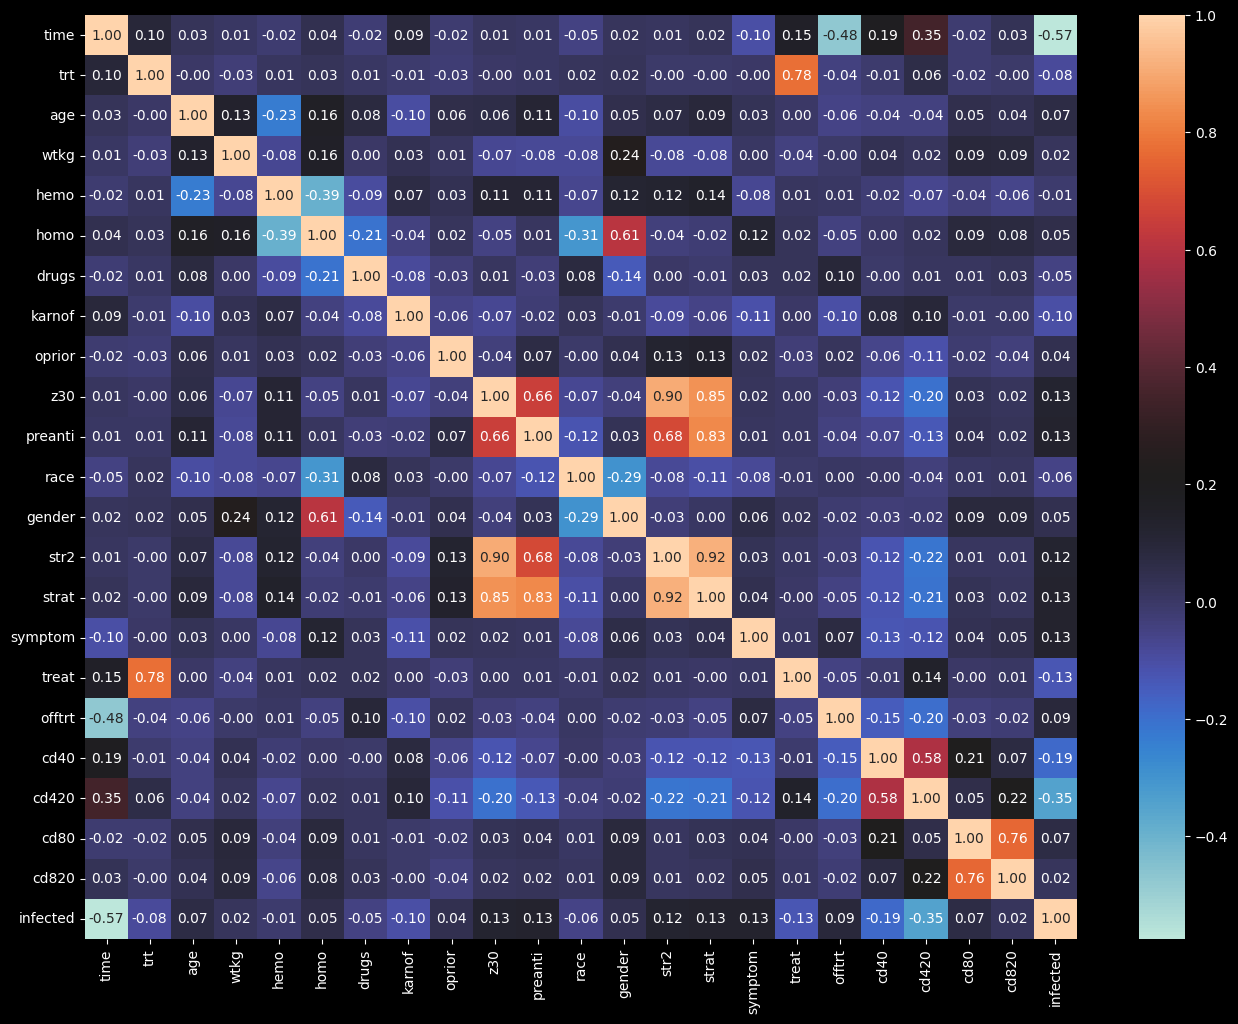

In [ ]:
plt.figure(figsize=(16, 12))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='icefire')
plt.show()

In [ ]:
def mPlotter(r, c, size, _targets, text):

    bg = '#010108'

    palette = ['#df5337', '#d24644', '#f7d340', '#3339FF', '#440a68', '#84206b', '#f1ef75', '#fbbe23', '#400a67']

    font = 'sans-serif'

    fig = plt.figure(figsize=size)

    fig.patch.set_facecolor(bg)

    grid = fig.add_gridspec(r, c)

    grid.update(wspace=0.5, hspace=0.25)

    __empty_diff = ((r * c) - 1) - len(_targets)

    axes = []

    for i in range(r):
        for j in range(c):
            axes.append(fig.add_subplot(grid[i, j]))

    for idx, ax in enumerate(axes):
        ax.set_facecolor(bg)

        if idx == 0:
            ax.spines["bottom"].set_visible(False)
            ax.tick_params(left=False, bottom=False)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.5, 0.5,
                 f'{text}',
                 horizontalalignment='center',
                 verticalalignment='center',
                 fontsize=18,
                 fontweight='bold',
                 fontfamily=font,
                 color="#fff")
        else:
            if (idx - 1) < len(_targets):
                ax.set_title(_targets[idx - 1].capitalize(), fontsize=14, fontweight='bold', fontfamily=font, color="#fff")
                ax.grid(color='#fff', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
                ax.set_xlabel("")
                ax.set_ylabel("")
            else:
                ax.spines["bottom"].set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])

        ax.spines["left"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    def cb(ax):
        ax.set_xlabel("")
        ax.set_ylabel("")

    if __empty_diff > 0:
        axes = axes[:-1*__empty_diff]

    return axes, palette, cb

In [ ]:
target = 'infected'
cont_cols = ['time', 'age', 'wtkg', 'preanti', 'cd40', 'cd420', 'cd80', 'cd820']
dis_cols = list(set(df.columns) - set([*cont_cols, target]))

len(cont_cols), len(dis_cols)

(8, 14)

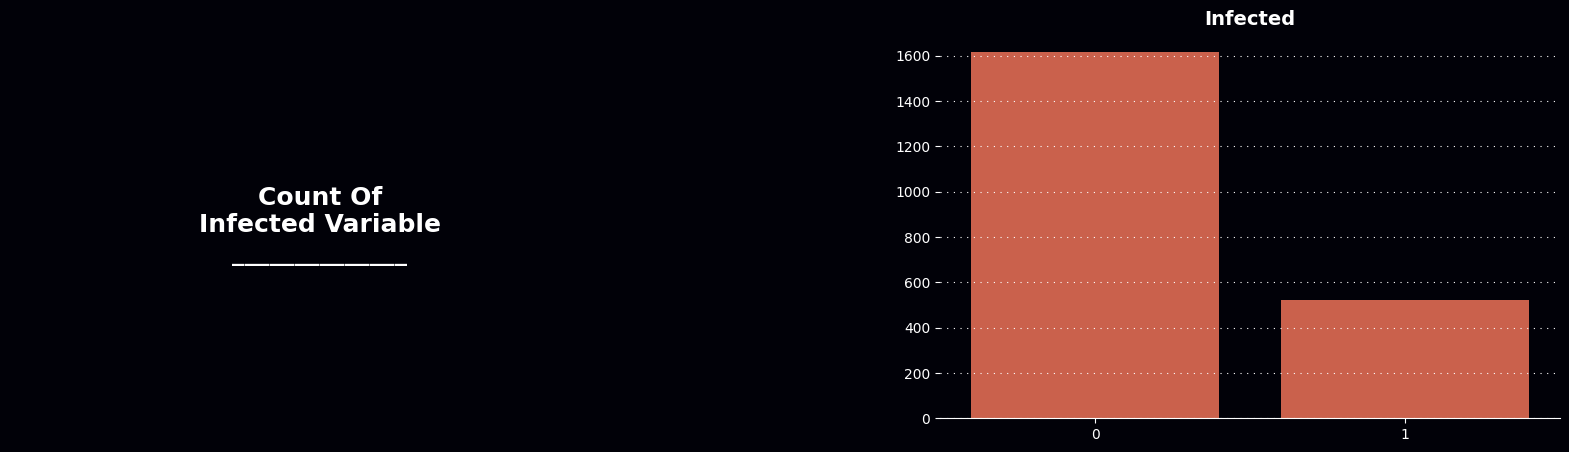

In [ ]:
axes, palette, cb = mPlotter(1, 2, (20, 5), [target], 'Count Of\nInfected Variable\n______________')
sns.countplot(x=df[target], ax = axes[1], color=palette[0])
cb(axes[1])

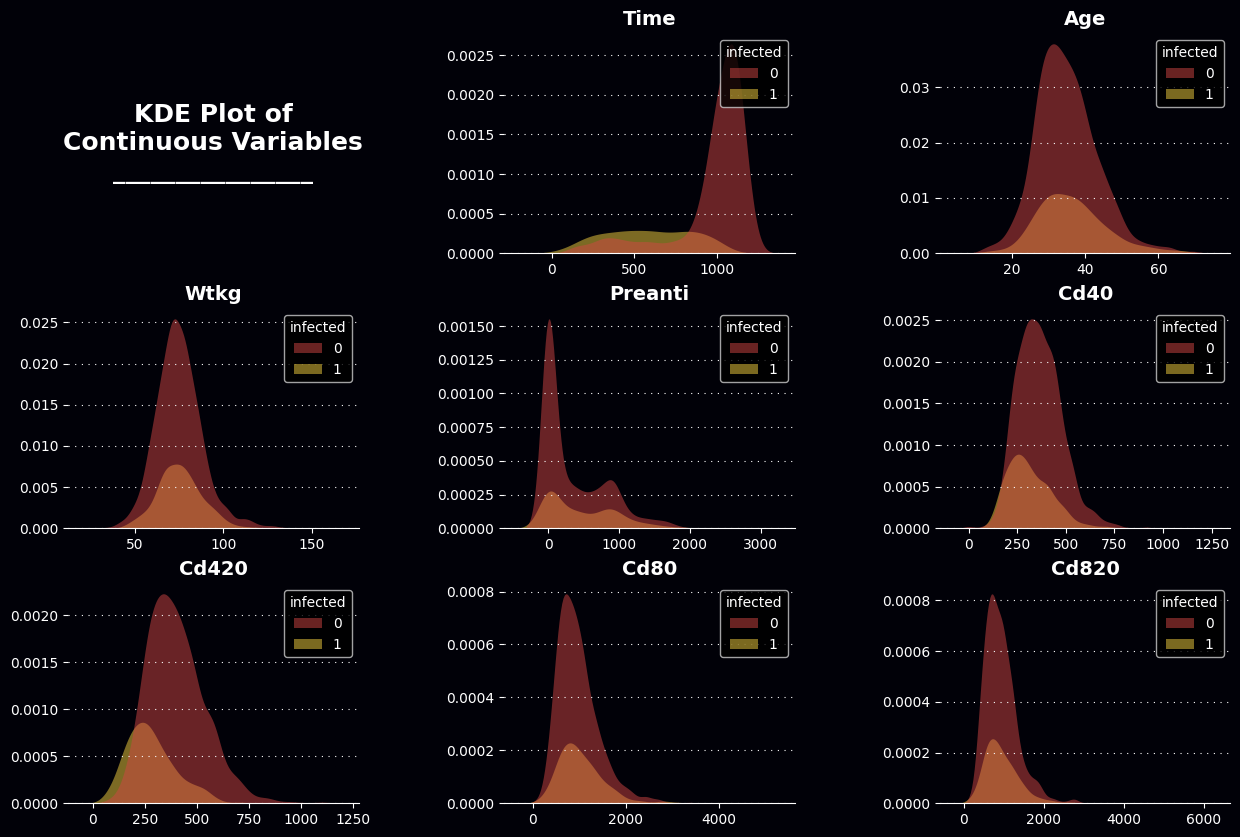

In [ ]:
axes, palette, cb = mPlotter(3, 3, (15, 10), cont_cols,'KDE Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.kdeplot(data=df, x=col, ax=ax, hue=target, palette=palette[1:3], alpha=.5, linewidth=0, fill=True)
    cb(ax)

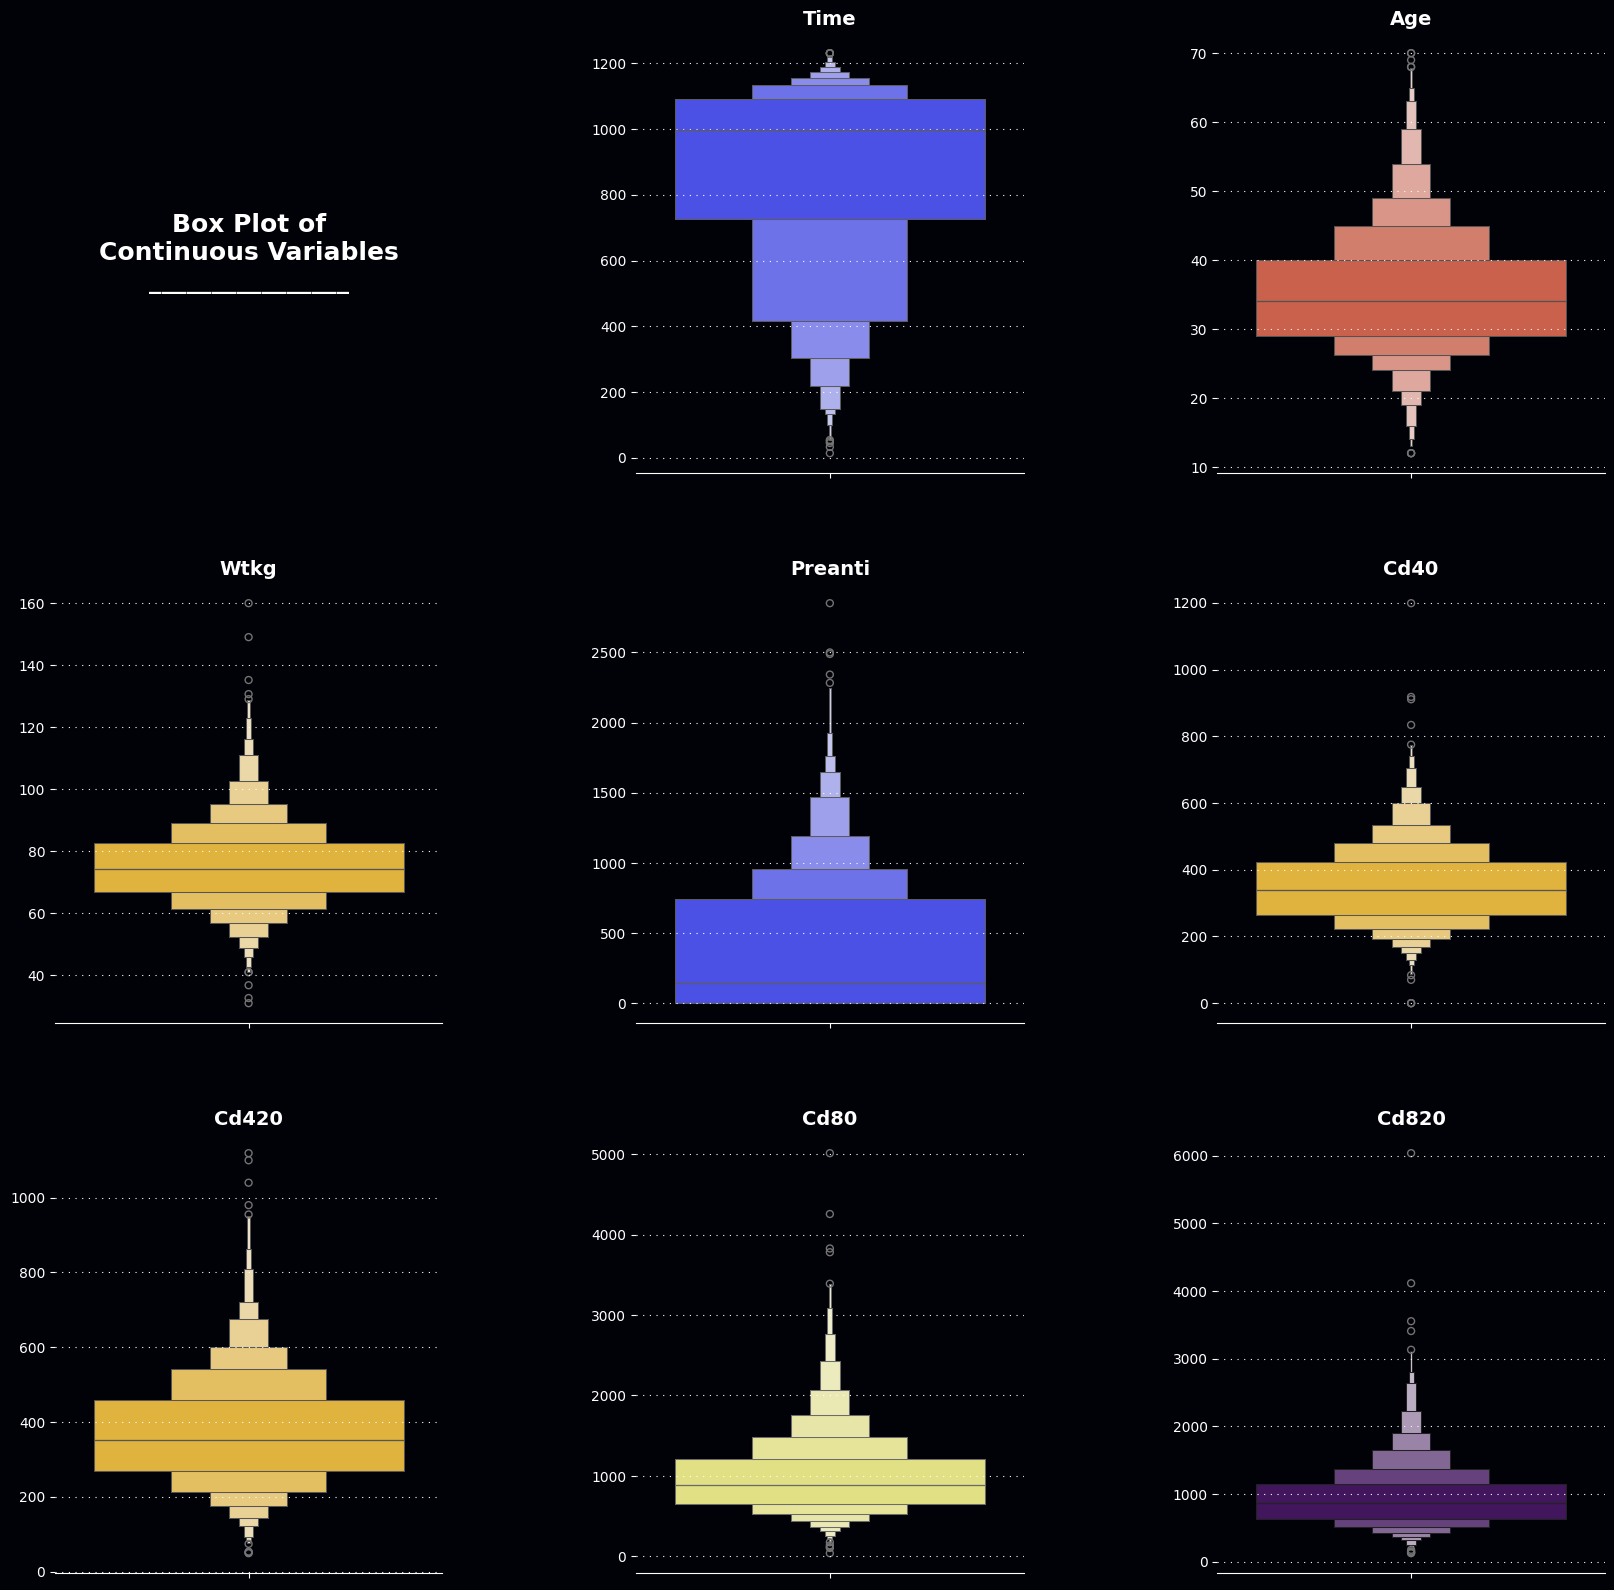

In [ ]:
axes, palette, cb = mPlotter(3, 3, (20, 20), cont_cols, 'Box Plot of\nContinuous Variables\n________________')

for col, ax in zip(cont_cols, axes[1:]):
    sns.boxenplot(data=df, y=col, ax=ax, palette=[palette[random.randint(0, len(palette)-1)]])
    cb(ax)

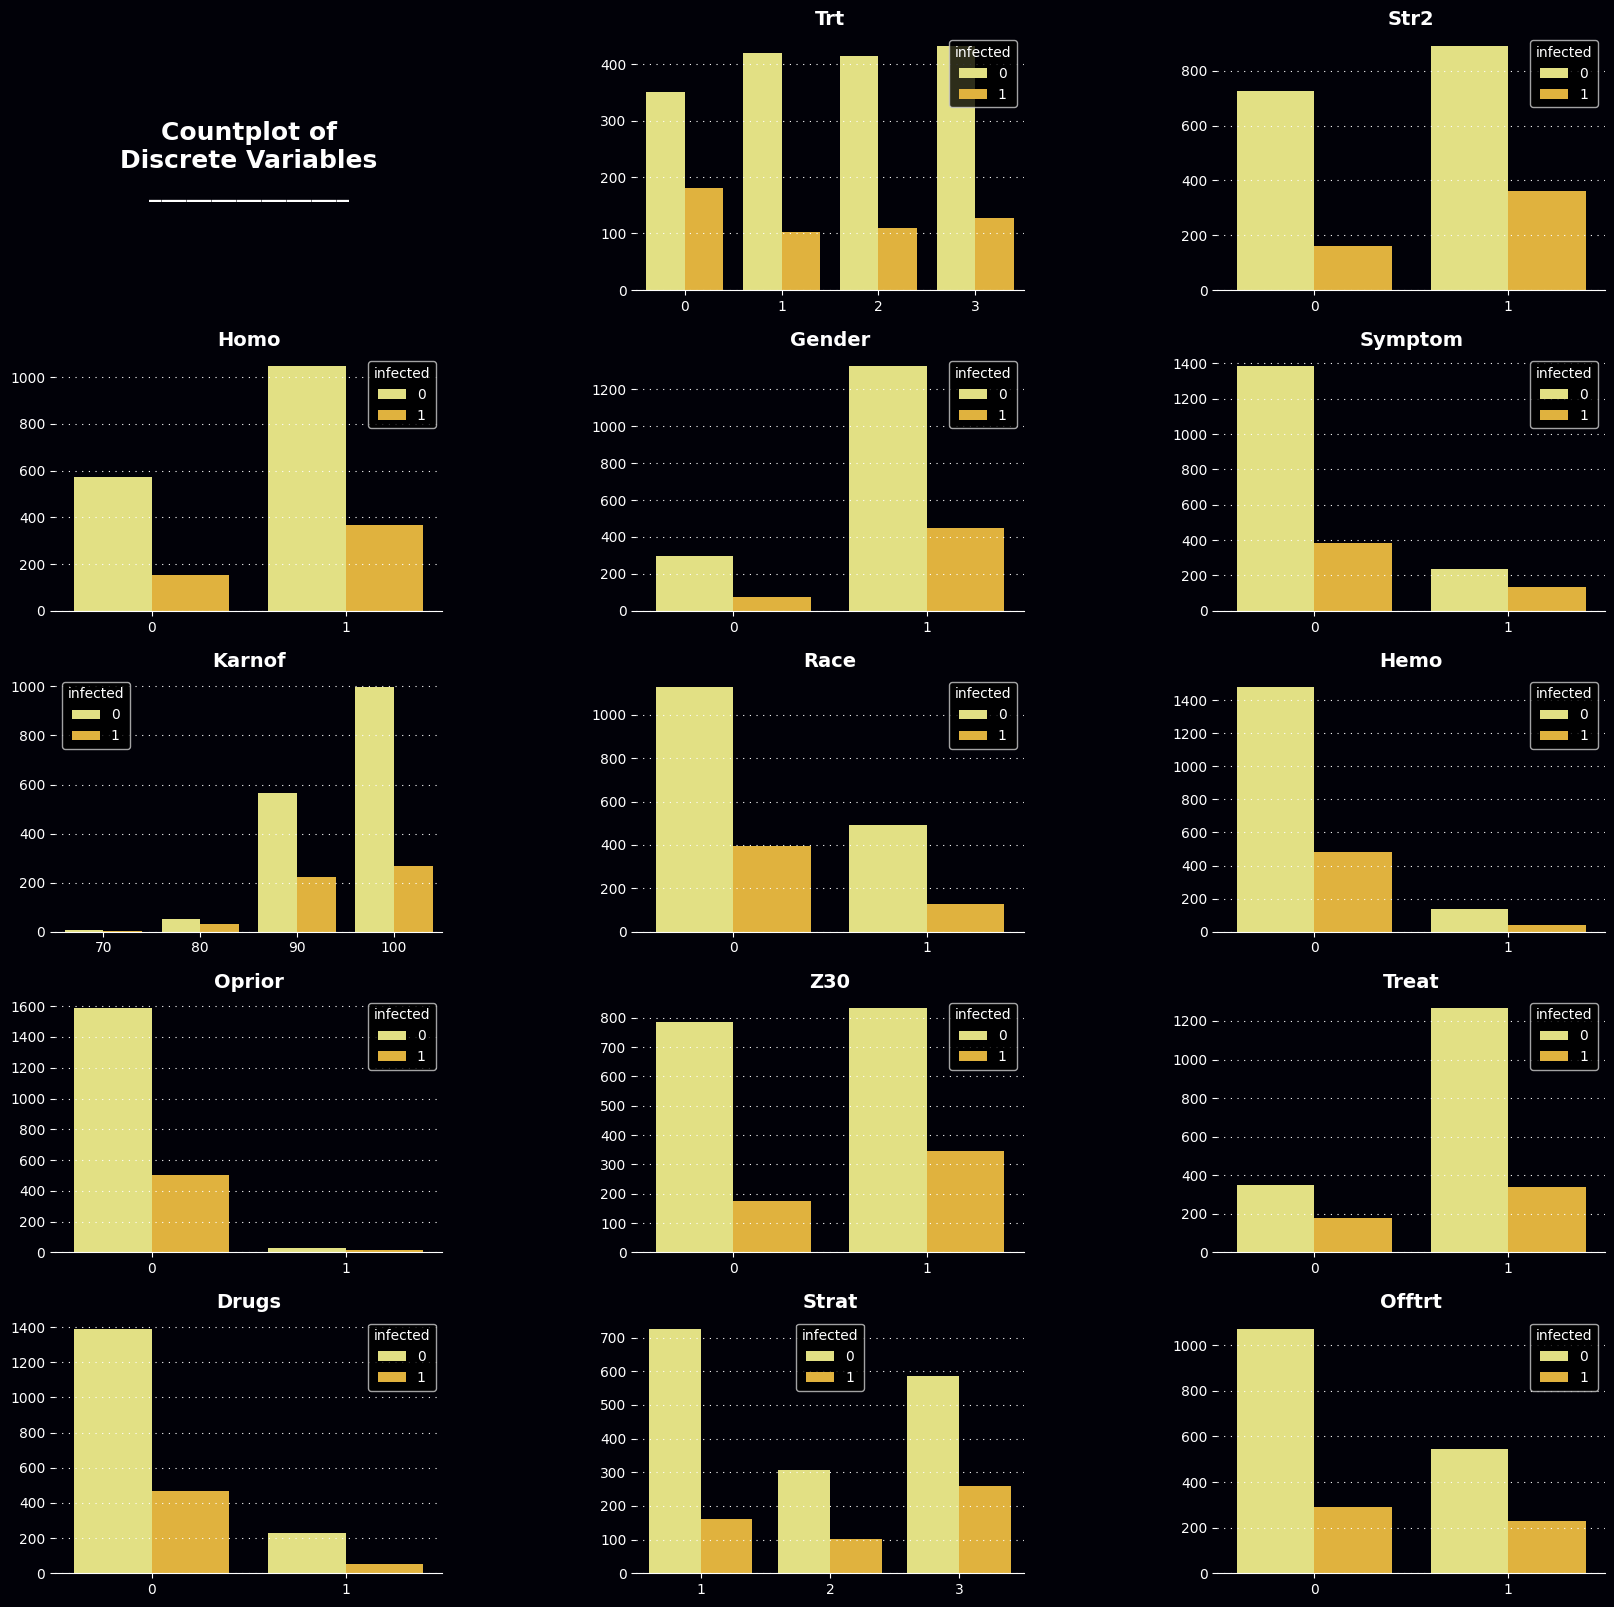

In [ ]:
axes, palette, cb = mPlotter(5, 3, (20, 20), dis_cols, 'Countplot of\nDiscrete Variables\n________________')

for col, ax in zip(dis_cols, axes[1:]):
    sns.countplot(x=df[col], ax = ax, hue=df[target], palette=palette[6:8])
    cb(ax)

In [ ]:
ax = px.scatter_3d(df, x="age", y="wtkg", z="time", template= "ggplot2", color="infected")
ax.show()

In [ ]:
ax = px.scatter_3d(df, x="preanti", y="cd40", z="cd420", template= "ggplot2", color="infected")
ax.show()

In [ ]:
ax = px.scatter_3d(df, x="preanti", y="cd80", z="cd820", template= "ggplot2", color="infected")
ax.show()

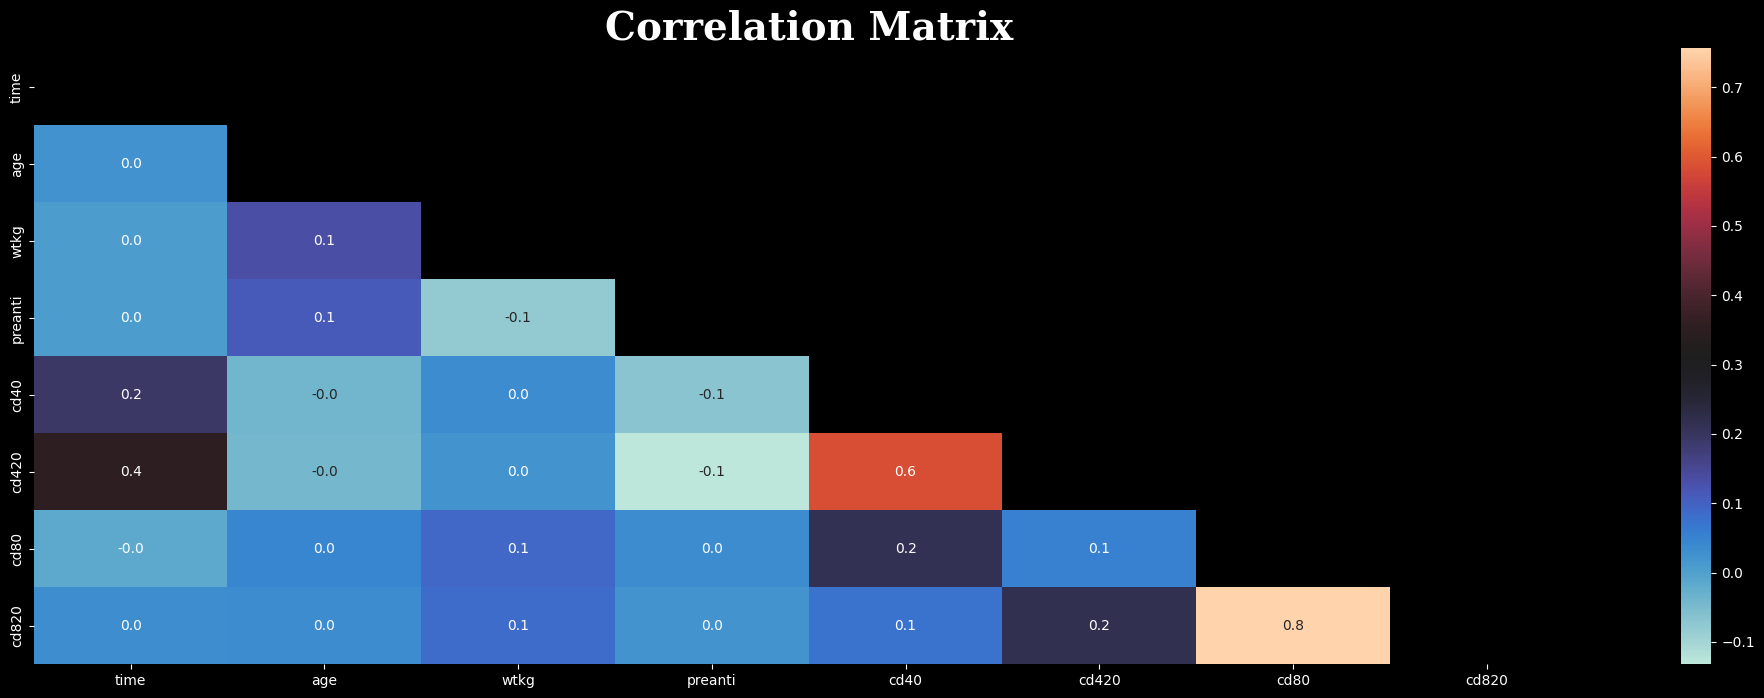

In [ ]:
fig = plt.figure(figsize=(25, 8))

gs = fig.add_gridspec(1, 1)

gs.update(wspace=0.3, hspace=0.15)

ax = fig.add_subplot(gs[0, 0])

ax.set_title("Correlation Matrix", fontsize=28, fontweight='bold', fontfamily='serif', color="#fff")

sns.heatmap(df[cont_cols].corr().transpose(), mask=np.triu(np.ones_like(df[cont_cols].corr().transpose())), fmt=".1f", annot=True, cmap='icefire')

plt.show()

### Data Splitting, Balancing & Scaling

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:, -1], random_state=3, train_size=.7)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1497, 22), (1497,), (642, 22), (642,))

In [ ]:
smote = SMOTE(random_state = 14)
x_train, y_train = smote.fit_resample(x_train, y_train)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((2246, 22), (2246,), (642, 22), (642,))

In [ ]:
x_train = MinMaxScaler().fit_transform(x_train)
x_test = MinMaxScaler().fit_transform(x_test)

## Models

---



### CatBoostClassifier


#### Parameter Tuning

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'depth': trial.suggest_int('depth', 1, 12),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'thread_count': -1,
        'loss_function': 'MultiClass',
        'eval_metric': 'Accuracy',
        'verbose': False
    }

    model = CatBoostClassifier(**params)

    model.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=False, early_stopping_rounds=20)

    y_pred = model.predict(x_test)

    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=50, show_progress_bar=True)

[I 2024-12-25 11:43:44,678] A new study created in memory with name: no-name-cbf0da0a-0ad2-4252-bde1-566bd715b252


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-12-25 11:43:48,459] Trial 0 finished with value: 0.8987538940809969 and parameters: {'iterations': 907, 'learning_rate': 0.03882507342038095, 'depth': 10, 'l2_leaf_reg': 0.0016888871532927618, 'border_count': 214}. Best is trial 0 with value: 0.8987538940809969.
[I 2024-12-25 11:43:48,648] Trial 1 finished with value: 0.8707165109034268 and parameters: {'iterations': 636, 'learning_rate': 0.020560357868490156, 'depth': 3, 'l2_leaf_reg': 6.5493612916933746, 'border_count': 104}. Best is trial 0 with value: 0.8987538940809969.
[I 2024-12-25 11:43:48,752] Trial 2 finished with value: 0.8894080996884736 and parameters: {'iterations': 522, 'learning_rate': 0.09016555739654937, 'depth': 4, 'l2_leaf_reg': 0.006752542474591361, 'border_count': 165}. Best is trial 0 with value: 0.8987538940809969.
[I 2024-12-25 11:43:49,080] Trial 3 finished with value: 0.8878504672897196 and parameters: {'iterations': 570, 'learning_rate': 0.018645921712461114, 'depth': 6, 'l2_leaf_reg': 6.312913829913

#### Model Fitting

In [ ]:
model = CatBoostClassifier(
    verbose=0,
    random_state=3,
    **study.best_params
)

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

#### Results

In [ ]:
y_pred_proba = model.predict_proba(x_test)
binary_loss = log_loss(y_test, y_pred_proba)
print(f"Binary Cross-Entropy Loss (Log Loss): {binary_loss}")

Binary Cross-Entropy Loss (Log Loss): 0.5029021194099508


In [ ]:
print (classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       495
           1       0.76      0.69      0.72       147

    accuracy                           0.88       642
   macro avg       0.83      0.81      0.82       642
weighted avg       0.88      0.88      0.88       642



<Axes: >

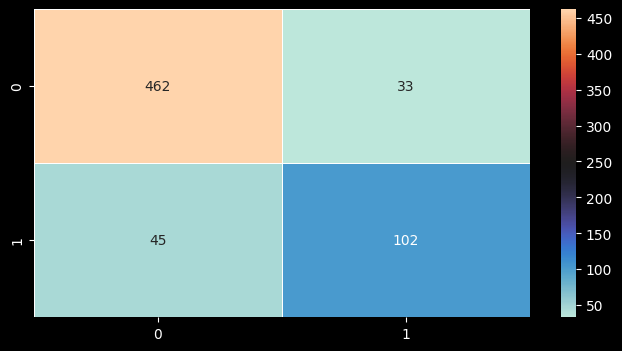

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True, fmt="d", cmap="icefire", linewidths=.5)

### DecisionTreeClassifier

In [ ]:
Dtree = DecisionTreeClassifier()

In [ ]:
Dtree.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred_Dtree = Dtree.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_Dtree))

              precision    recall  f1-score   support

           0       0.90      0.85      0.88       495
           1       0.58      0.69      0.63       147

    accuracy                           0.82       642
   macro avg       0.74      0.77      0.76       642
weighted avg       0.83      0.82      0.82       642



<Axes: >

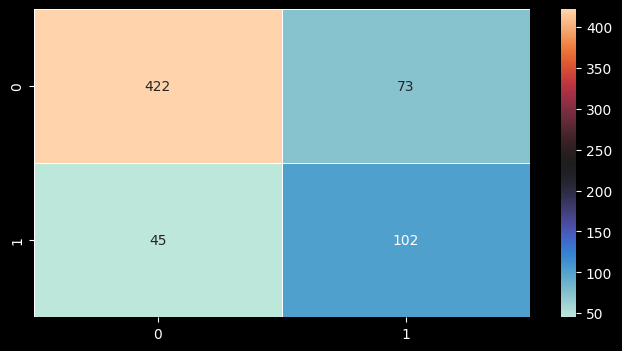

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test,y_pred_Dtree), annot = True, fmt="d", cmap="icefire", linewidths=.5)

### RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier()

In [ ]:
rfc.fit(x_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred_rfc = rfc.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_rfc))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       495
           1       0.81      0.67      0.74       147

    accuracy                           0.89       642
   macro avg       0.86      0.81      0.83       642
weighted avg       0.89      0.89      0.89       642



<Axes: >

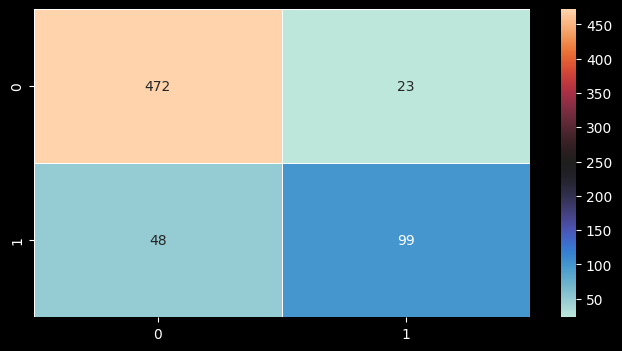

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test,y_pred_rfc), annot = True, fmt="d", cmap="icefire", linewidths=.5)

### Logistic Regression

In [ ]:
log_reg = LogisticRegression()

In [ ]:
log_reg.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred_log_reg = log_reg.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_log_reg))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       495
           1       0.70      0.73      0.72       147

    accuracy                           0.87       642
   macro avg       0.81      0.82      0.82       642
weighted avg       0.87      0.87      0.87       642



In [ ]:
y_pred_prob = log_reg.predict_proba(x_test)

log_loss_value = log_loss(y_test, y_pred_prob)

print(f'Log Loss: {log_loss_value}')

Log Loss: 0.36416895927434784


<Axes: >

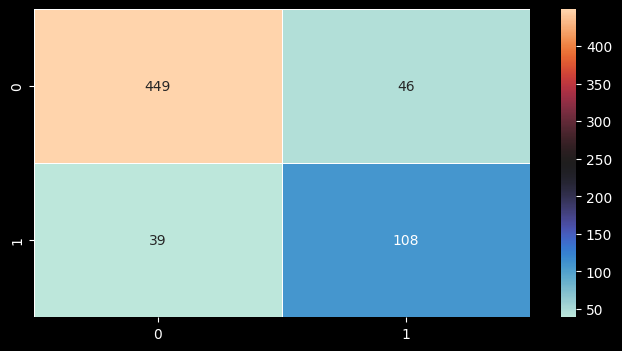

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(y_test,y_pred_log_reg), annot = True, fmt="d", cmap="icefire", linewidths=.5)

---